<a href="https://colab.research.google.com/github/HeshanNavindu-7/oilspill-detection/blob/main/oilspill_VGG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill


100%|██████████| 26.5M/26.5M [00:00<00:00, 86.6MB/s]


In [15]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




test
train


Train Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


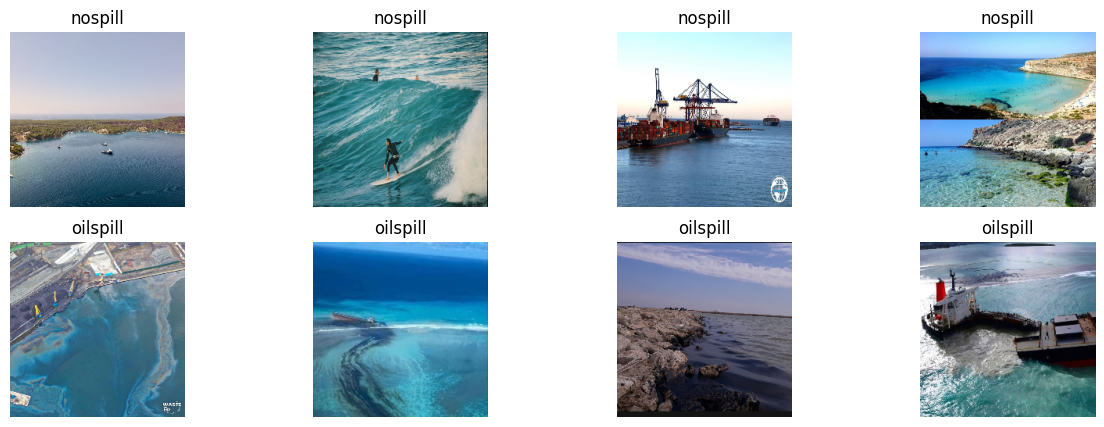

Test Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


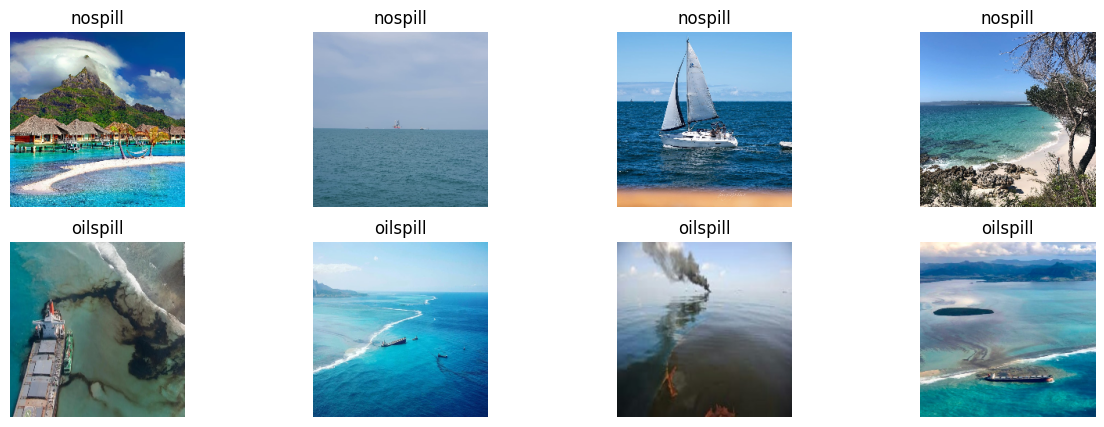

In [16]:
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

# Define image size and batch size
target_size = (224,224)
batch_size = 32

# Define classes
classes = ['nospill', 'oilspill']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


In [17]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# Define image target size and batch size
target_size = (224, 224)
batch_size = 32

# Define the generator model for GAN
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 56 * 56, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((56, 56, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7, 7), activation='tanh', padding='same'))
    return model

# Define the discriminator model for GAN
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN configuration
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator((224, 224, 3))
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# Function to generate synthetic images
def generate_synthetic_images(generator, n_samples, latent_dim):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    synthetic_images = generator.predict(noise)
    synthetic_images = (synthetic_images + 1) / 2.0  # Rescale to [0,1]
    return synthetic_images

# Generate synthetic images
n_synthetic_images = 1000
synthetic_images = generate_synthetic_images(generator, n_synthetic_images, latent_dim)

# Combine synthetic images with real images using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Load real images from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Get a batch of real images
real_images, real_labels = next(train_generator)
real_images = real_images[:n_synthetic_images]  # Adjust to match synthetic images count

# Concatenate real and synthetic images
all_images = np.concatenate((real_images, synthetic_images), axis=0)
all_labels = np.concatenate((real_labels, np.zeros(n_synthetic_images)), axis=0)  # Adjust labels as needed

# Create a new ImageDataGenerator for combined dataset
combined_datagen = ImageDataGenerator()
combined_generator = combined_datagen.flow(
    all_images,
    all_labels,
    batch_size=batch_size
)


32/32 [==============================] - 442s 14s/step
Found 197 images belonging to 2 classes.


Found 197 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 8.1407 - accuracy: 0.4518 
Epoch 1: val_accuracy improved from -inf to 0.55102, saving model to best_model.h5
7/7 [==============================] - 171s 25s/step - loss: 8.1407 - accuracy: 0.4518 - val_loss: 2.1573 - val_accuracy: 0.5510
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 2.1611 - accuracy: 0.5178 
Epoch 2: val_accuracy improved from 0.55102 to 0.63265, saving model to best_model.h5
7/7 [==============================] - 172s 25s/step - loss: 2.1611 - accuracy: 0.5178 - val_loss: 0.6459 - val_accuracy: 0.6327
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.1963 - accuracy: 0.6091 
Epoch 3: val_accuracy did not improve from 0.63265
7/7 [==============================] - 160s 23s/step - loss: 1.1963 - accuracy: 0.6091 - val_loss: 1.3144 - val_accuracy: 0.6327
Epoch 4/20
7/7 [=================

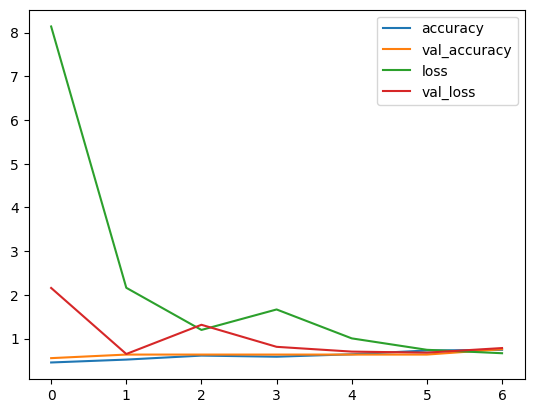

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define image target size and batch size
target_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Adjust rotation range
    width_shift_range=0.2,  # Adjust width shift range
    height_shift_range=0.2,  # Adjust height shift range
    shear_range=0.2,  # Adjust shear range
    zoom_range=0.1,  # Adjust zoom range
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the train and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Load VGG16 model with pre-trained weights, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Experiment with number of units
x = Dropout(0.5)(x)  # Experiment with dropout rate
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,  # Adjust as needed
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[checkpoint, early_stopping]
)

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


# test

In [19]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.1 MB/s eta 0:00:00


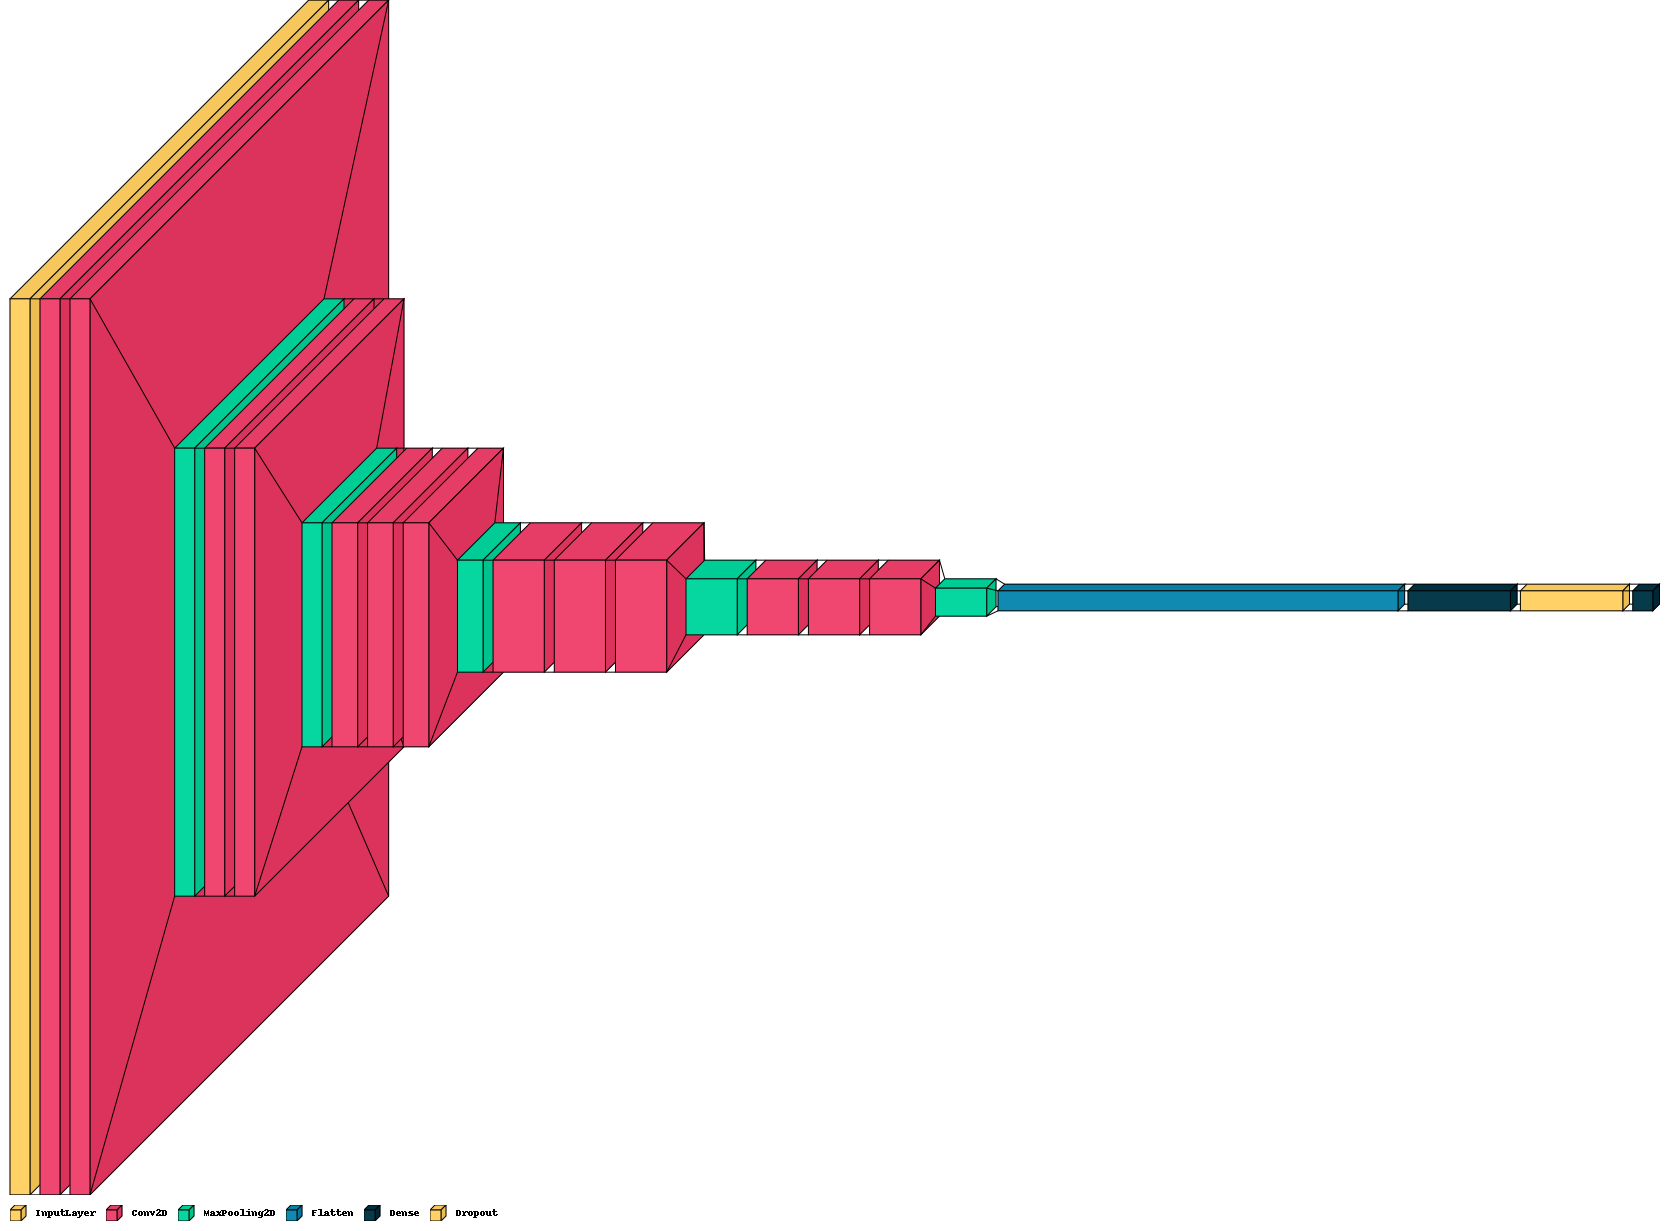

In [20]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [21]:

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2/2 [==============================] - 31s 11s/step - loss: 0.6459 - accuracy: 0.6327
Test Loss: 0.6458677053451538
Test Accuracy: 0.6326530575752258


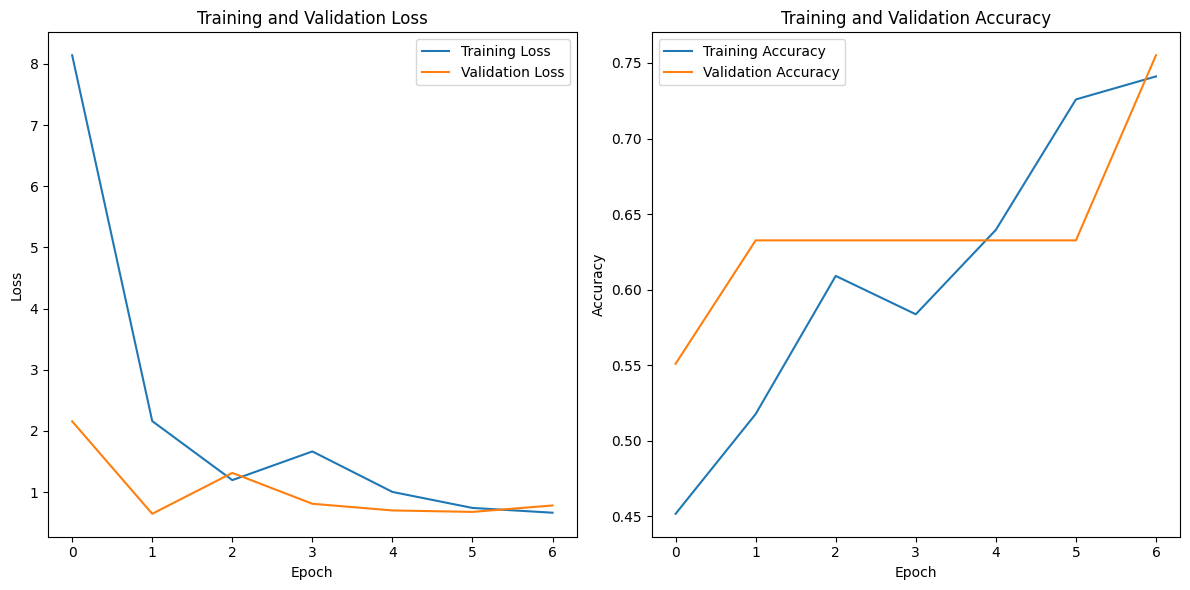

In [22]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()
